In [1]:
#enable to plot with matplotlib
%matplotlib inline

In [9]:
import sys
sys.path.append('../../xs_proc')
from xs_data_proc import *
from proc_data_ana import *
from visual_func import *
import matplotlib.pyplot as plt
from h5_data_search import id13_h5_search
import pyFAI
import numpy as np
import h5py
import os
import fabio
import time
import re
import warnings
warnings.filterwarnings('ignore')


In [3]:
proposal_path = "/data/visitor/sc5005/id13"
proposal_num  = "sc5005"
data_path     = 'entry_0000/measurement/data'
# the directory could be replaced by user with specific path
save_path     = os.getcwd()


t1 = id13_h5_search(proposal_path,proposal_num)

sample_keywords = [
                  #['MoBS_A_C1_9.1'],
                  #['WTCS1','8'],
                  #['WTCS1_b_mac1_strip1lr1_1.1'],
                  #['WTCS1_b_mac1_strip1lr1_2.1'],
                  #['WTCS1_c_mac1_strip1lr1_1.1'],
                  #['mac1','sup']
                  ['mount04_M22Lox_7'],
                  ]
samples = samples_for_process(t1,sample_keywords)

total_pttns,scan_shape,idx_list = scan_info(t1)
h5_list,path_idx,pttn_idx = scan_h5_data_info(t1,scan_shape,idx_list)

found dataset:
mount04_M22Lox_7.1

sample:
mount04

dataset:
mount04_M22Lox

scan:
scan00007

data information:
{'scan_type': 'akmap', 'fast_axis': 'nnp3', 'fast_axis_start_pos': 129.100006, 'fast_axis_end_pos': 135.100006, 'fast_axis_num_step': 240, 'slow_axis': 'nnp2', 'slow_axis_start_pos': 125.0, 'slow_axis_end_pos': 100.0, 'slow_axis_num_step': 25, 'exposure_time': 0.075}

detector position:
300.0

1 h5 files in this scan





In [4]:
def bkgd_cal(left_top,bottom_right,h5_list,path_idx,pttn_idx,
             data_path= 'entry_0000/measurement/data'):
    #left_top and bottom_right are the coordinate with (x,y) or (col,row)
    data = []
    for i in range(left_top[1],(bottom_right[1]+1)):
        for j in range(left_top[0],(bottom_right[1]+1)):
            with h5py.File(h5_list[path_idx[i,j]],'r') as f:
                data.append(f[data_path][pttn_idx[i,j]])
    data = np.array(data)
    return np.nanmean(data,axis=0)

bkgd = bkgd_cal((0,0),(5,5),h5_list,path_idx,pttn_idx)#[1150:1300,850:1100]

26.545389890670776
53.01822209358215


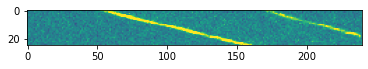

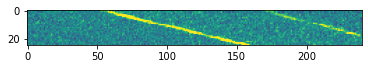

In [7]:
# need to subtract the background, otherwise too weak to observe the SAXS data
tm = time.time()
res = parallel_func(scan_pttn_roi_sum,12,np.arange(len(path_idx.flatten())),
                   h5_list=h5_list,
                   path_idx=path_idx.flatten(),
                   pttn_idx=pttn_idx.flatten(),
                   data_path=data_path,
                   left_top=(920,1140),
                   right_bottom=(970,1190),
                   bkgd=bkgd[1140:1190,920:970],
                   )
print(time.time()-tm)
roi_green = np.array(res).reshape(scan_shape)
pttn_of_int_map(roi_green,h5_list,path_idx,pttn_idx,log=False)

res = parallel_func(scan_pttn_roi_sum,12,np.arange(len(path_idx.flatten())),
                   h5_list=h5_list,
                   path_idx=path_idx.flatten(),
                   pttn_idx=pttn_idx.flatten(),
                   data_path=data_path,
                   left_top=(900,1280),
                   right_bottom=(950,1330),
                   bkgd=bkgd[1280:1330,900:950],
                   )
print(time.time()-tm)
roi_red = np.array(res).reshape(scan_shape)
pttn_of_int_map(roi_red,h5_list,path_idx,pttn_idx,log=False)


14.346120119094849
20.218199253082275


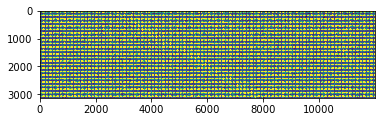

In [19]:
# need to mask high intensity near beam stop for stitch
tm = time.time()
res = parallel_func(scan_pttn_roi,12,np.arange(len(path_idx.flatten())),
                   h5_list=h5_list,
                   path_idx=path_idx.flatten(),
                   pttn_idx=pttn_idx.flatten(),
                   data_path=data_path,
                   left_top=(890,1100),
                   right_bottom=(990,1350),
                   bkgd=bkgd[1100:1350,890:990],
                   hlm = 10,
                   down_sample=2)
print(time.time()-tm)
stitch = stitch_roi(res,scan_shape[0],scan_shape[1],axis2_direction='positive')
print(time.time()-tm)
stitch[np.isnan(stitch)] = 0
plt.imshow(stitch,vmin=0,vmax=0.1)

In [20]:
c1 = [[ 906, 1233],
       [ 913, 1239],
       [ 918, 1246],
       [ 923, 1252],
       [ 933, 1256],
       [ 938, 1261],
       [ 943, 1256],
       [ 951, 1250],
       [ 961, 1241],
       [ 968, 1235],
       [ 972, 1224],
       [ 971, 1217],
       [ 966, 1211],
       [ 958, 1205],
       [ 949, 1201],
       [ 943, 1195],
       [ 935, 1197],
       [ 925, 1204],
       [ 917, 1211],
       [ 910, 1220],
       [ 906, 1224]]

m1 = mask_making(bkgd,vertex=[c1],low_int_thrshd=-0.1,high_int_thrshd=50)

10.359252214431763
17.281795263290405


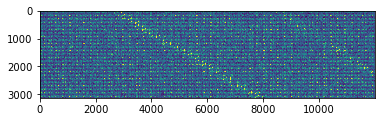

In [21]:
tm = time.time()
res = parallel_func(scan_pttn_roi,12,np.arange(len(path_idx.flatten())),
                   h5_list=h5_list,
                   path_idx=path_idx.flatten(),
                   pttn_idx=pttn_idx.flatten(),
                   data_path=data_path,
                   left_top=(890,1100),
                   right_bottom=(990,1350),
                   bkgd=bkgd[1100:1350,890:990],
                   mask=m1[1100:1350,890:990],
                   hlm = 10,
                   down_sample=2)
print(time.time()-tm)
stitch = stitch_roi(res,scan_shape[0],scan_shape[1],axis2_direction='positive')
print(time.time()-tm)
stitch[np.isnan(stitch)] = 0
plt.imshow(stitch,vmin=0,vmax=0.1)